In [ ]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torch.nn import functional as F
import torchvision
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
import os
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose(
    [
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    ])
test_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
cifar10 = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=test_transform)

batch_size = 32
n = batch_size
dataloader = DataLoader(cifar10, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_test = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Backprop Your Own Gradients

In this section you will backprop your gradients through a loss function. Below you fill find an implementation of a loss function in multiple steps, an integrated loss function implementation and finally a partial implementation of an autograd function.

Your taks is to implement the backward passes for these functions and verify that your implementation is correct. This section will teach you how to write your own custom differentiable loss function and how to implement it in a way that fits in with standard pytorch classes.

In [ ]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def compare(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [ ]:
model = nn.Sequential(
    # Conv2d( in_channels, out_channels, kernel_size) B,3,32,32
    nn.Conv2d(3, 32, 3, stride= 2, padding=1),  nn.BatchNorm2d(32), nn.Tanh(), # B,32,16,16
    nn.Conv2d(32, 64, 3, stride= 2, padding=1), nn.BatchNorm2d(64), nn.Tanh(), # B,32,8,8
    nn.Conv2d(64, 128, 3, stride= 2, padding=1), nn.BatchNorm2d(128), nn.Tanh(), # B,32,4,4
    nn.Flatten(),
    nn.Linear(4*4*128, 64), nn.BatchNorm1d(64), nn.Tanh(),
    nn.Linear(64, 10)
)

optim = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.00001)

In [ ]:
batch = next(iter(dataloader))
x = batch[0]
y = batch[1]

logits = model(x)

### Writing backward pass

Backprop through the loss function manually, backpropagating through exactly all of the variables as they are defined in the forward pass below, one by one starting from the end and propagating to the beginning.

I have included notes and clues that will help you in backpropogation. Keep in mind that a derrivative for a variable should be the same shape as the orignal variable. Remember that if there is a broadcast operation in the forward pass you need to have a summing operation in the backward pass and if there is a summation in the forward pass you need to have a broadcast operation in the backward pass.

In [ ]:
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), y].mean()

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,
          norm_logits, logit_maxes, logits]:
  t.retain_grad()

optim.zero_grad()
loss.backward()
loss

tensor(2.3574, grad_fn=<NegBackward0>)

In [ ]:
# ----------------------
# Write your answer here

# You should consider which parts of the logprops is affecting the loss
# Only backpropagate the gradients to those elements
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), y] = -1.0/n * 1

# d/dx(log(x))= 1/x
dprobs = (1/probs) * dlogprobs

# Broadcasing in forward means summation in backward
dcounts_sum_inv = (dprobs * counts).sum(1, keepdims=True)

# d/dx(1/x) = -x**-2
dcounts_sum = -dcounts_sum_inv * (counts_sum ** -2)

# Remember that there are counts is used both for counts_sum and probs
# so it should have 2 additive contributions
# Remember that summation in forward pass is broadcasting in backward pass
dcounts = dprobs * counts_sum_inv + dcounts_sum

# d/dx(e^x)= e^x
dnorm_logits = dcounts * counts

# d/dx(-x)= -1 and broadcasing in forward means summation in backward
dlogit_maxes = -dnorm_logits.sum(1, keepdims=True)

# Remember that there are counts is used both for logit_maxes and norm_logits
# so it should have 2 additive contributions
# For the first component remember d/dx(x)= 1
# For the second component remember to only affect the indices have max values
dlogits = dnorm_logits + torch.where(logits == logit_maxes, dlogit_maxes, torch.tensor(0.0, dtype=torch.float64))

"""
Initially, the problem was that the logits calculation was returning exact: False during the comparison,
even though all other components were exact: True. This error occurred because I was incorrectly propagating the effect of
logit_maxes across all logits, rather than targeting only the indices with the maximum values.
By adjusting the backpropagation to specifically use 'torch.where' for those indices,
the gradients were correctly limited, which fixed the issue and made the logits comparison exact: True.

dlogits = dnorm_logits + dlogit_maxes

"""
# ----------------------

#YOU WILL USE THE COMPARE FUNCTIONS BELOW TO SEE IF YOU HAVE THE CORRECT SOLUTION OR NOT
#ALSO THEY WILL BE USED IN THE GRADING PROCESS, RUN THEM ALL AND KEEP THEIR PRINTOUTS
compare('logprobs', dlogprobs, logprobs)
compare('probs', dprobs, probs)
compare('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
compare('counts_sum', dcounts_sum, counts_sum)
compare('counts', dcounts, counts)
compare('norm_logits', dnorm_logits, norm_logits)
compare('logit_maxes', dlogit_maxes, logit_maxes)
compare('logits', dlogits, logits)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0


### Simplifying Cross-Entropy Expression


Backprop through cross_entropy function in one step. Look at the mathematical expression for cross entropy $-\sum_{c=1}^{10}y_{c}\log(p_c)$, calculate the derivative analytically (with pen and paper) and finally write down the simplified expression for the backpropagation calculation.

Remember that in order to convert the logits into propabilities $p$ we need to take the softmax. Since the labels are one-hot only the labels that are correct are going to affect the final loss $L$ and the expression for cross entropy can be simplified to
$L=-log(\frac{e^{logit_y}}{\sum_{j}e^{logit_j}})$.

Take the derivative of the loss with respect to the each dimension of the logit $logit_i$. Remember that you can simplify the experssion by considering two cases. One where $i=y$ and one where $i\neq y$.

Finally remember that we are calculating the loss over the batches and we need to average the losses over the batch dimension (i.e. divide by batch_size)

Note: Your answer don't have to produce the exactly same result as the Pytorch implementation you can get an approximately correct version that has less max difference than 1e-8.

In [ ]:
# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum)
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, y)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

2.357421875 diff: 4.76837158203125e-07


In [ ]:
# ----------------------
# Write your answer here

dlogits = probs.clone()
dlogits[range(n), y] -= 1
dlogits /= n

"""
I calculate dlogits by copying probs because, during backpropagation of the cross-entropy loss,
I need to adjust the gradient for the true class. I subtract 1 from the probabilities of the true labels (y)
and then divide by n to normalize the gradient across the batch, ensuring that the loss is averaged properly.

Result is within the acceptable range.
The max difference for logits  is less than 1e-8, satisfying the requirement for approximate correctness.

"""

# ----------------------
#THE CODE BELOW AND IT'S OUTPUT WILL BE USED IN THE GRADING PROCESS
#USE IT TO TEST YOUR SOLUTION
compare('logits', dlogits, logits) # It is ok to get approximate correctness, 1e-8 is OK

logits          | exact: False | approximate: True  | maxdiff: 4.190951585769653e-09


### Defining new Autograd function

Now use your solution from the previous step to write a cutom autograd Function. You can take a look at the [documententation](https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html) for autograd functions in order to get a clearer idea.

For the forward pass we have already provided the implementation steps. You don't need to backpropagate the loss with respect to the labels they are return with None in the template



In [ ]:
class CustomCrossEntropy(torch.autograd.Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """

    @staticmethod
    def forward(ctx, logits, y):
        """CustomCrossEntropy.apply
        Here we save the elements necessary for calculating the backward pass.
        We than use the efficient expression for the backward pass.
        """
        ctx.save_for_backward(logits, y)
        return F.cross_entropy(logits, y)

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        We first load the tensors that we have saved before
        Calculate the local derivative and backpropagate it by multiplying the upstream
        derivative with the local derivative. You don't need to backpropagate the gradient
        for y and return None since we expect it to be a fixed value.
        """
        logits, y, = ctx.saved_tensors


        # ----------------------
        # Write your answer here

        n = logits.size(0)  # Batch size

        # Calculate the softmax probabilities
        probs = F.softmax(logits, dim=1)
        dlogits = probs.clone()
        dlogits[range(n), y] -= 1  # Subtract 1 for the correct class indices
        dlogits /= n  # Normalize by batch size

        # Multiply by grad_output to handle upstream gradients, adjusting for shape
        dlogits *= grad_output.view(-1, 1)

        return dlogits, None
        # ----------------------

Below is a check for you to make sure that your code has been implemented correctly.

In [ ]:
#THE CODE BELOW AND IT'S OUTPUT WILL BE USED IN THE GRADING PROCESS
#USE IT TO TEST YOUR SOLUTION
batch = next(iter(dataloader))
x = batch[0]
y = batch[1]

# Calculate loss and gradients using Pytorch CrossEntropy method
logits = model(x)
loss = F.cross_entropy(logits, y)

logits.retain_grad()

optim.zero_grad()
loss.backward()

pytorch_logits_grad = logits.grad

print("pytorch cross entropy loss: ",loss)

# Calculate loss using new CustomCrossEntropy method
logits = model(x)
loss_fn = CustomCrossEntropy.apply
loss = loss_fn(logits, y)

logits.retain_grad()

optim.zero_grad()
loss.backward()

custom_logits_grad = logits.grad
print("custom cross entropy loss: ",loss)

torch.allclose(custom_logits_grad, pytorch_logits_grad)


#The custom autograd function `CustomCrossEntropy` successfully replicates the behavior of PyTorch's `cross_entropy`:
#The calculated loss values match, as shown by identical outputs from both methods
#The gradient check (`torch.allclose`) returns `True`, indicating that the backward pass is implemented correctly.
#This means the `dlogits` calculation and normalization are accurate.


pytorch cross entropy loss:  tensor(2.3838, grad_fn=<NllLossBackward0>)
custom cross entropy loss:  tensor(2.3838, grad_fn=<CustomCrossEntropyBackward>)


True

## Architecture Optimization

### Convolutional Architecture



Below you find the model definition for a Convolutional neural network. Your task is to optimize the network architecture below to improve the model performance. **The minimum criteria for success is %85 validation accuracy.**

You are free to use other components like MaxPool2d, Dropout and ReLU from torch.nn library. Please remember the architectural innovations and regularization methods mentioned in the class and try to emulate them here. You can also change augmentation, learning rate schedulers and optimization methods as you like. Don't use predefined models right away but you can reimplement them yourselves.

You can define blocks and bottleneck layers to define your architecture.

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F

# Data Augmentation Transformations with Mixup or Cutout
transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
])

# Model Definition with additional bottleneck layers and residual connections
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(4*4*512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(-1, 4*4*512)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

model = CustomCNN().to('cuda')

# Optimizer and Scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

In [ ]:
# Moving Model to CUDA
model = model.to('cuda')

# Training loop with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
early_stopping_patience = 15
no_improvement_epochs = 0
best_accuracy = 0.0

# Initialize list to store training loss
losses = []
validation_accuracies = []

In [ ]:
for epoch in range(40):
    model.train()
    epoch_loss = 0

    for batch_idx, batch in enumerate(dataloader):
        optimizer.zero_grad()
        x = batch[0].to('cuda').float()
        y = batch[1].to('cuda')

        logits = model(x)
        loss = F.cross_entropy(logits, y)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    scheduler.step()
    avg_epoch_loss = epoch_loss / len(dataloader)
    losses.append(avg_epoch_loss)  # Append average epoch loss to losses list
    print(f"Epoch {epoch} completed with average loss: {avg_epoch_loss}")

    # Validation accuracy calculation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader_test:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = 100 * correct / total
    validation_accuracies.append(validation_accuracy)  # Append validation accuracy
    print(f"Validation Accuracy after epoch {epoch}: {validation_accuracy}%")

    # Early stopping check
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        no_improvement_epochs = 0
    else:
        no_improvement_epochs += 1

    if no_improvement_epochs >= early_stopping_patience:
        print("Early stopping triggered")
        break

Epoch 0 completed with average loss: 1.4242059251320949
Validation Accuracy after epoch 0: 66.88%
Epoch 1 completed with average loss: 1.018200092718377
Validation Accuracy after epoch 1: 74.92%
Epoch 2 completed with average loss: 0.8543846648775151
Validation Accuracy after epoch 2: 77.93%
Epoch 3 completed with average loss: 0.7420566521313278
Validation Accuracy after epoch 3: 80.73%
Epoch 4 completed with average loss: 0.6673512835572792
Validation Accuracy after epoch 4: 82.6%
Epoch 5 completed with average loss: 0.5818863744946985
Validation Accuracy after epoch 5: 84.24%
Epoch 6 completed with average loss: 0.5212009690811599
Validation Accuracy after epoch 6: 85.98%
Epoch 7 completed with average loss: 0.472598548594836
Validation Accuracy after epoch 7: 86.79%
Epoch 8 completed with average loss: 0.4353934978578843
Validation Accuracy after epoch 8: 87.19%
Epoch 9 completed with average loss: 0.4201395924579083
Validation Accuracy after epoch 9: 87.27%
Epoch 10 completed with

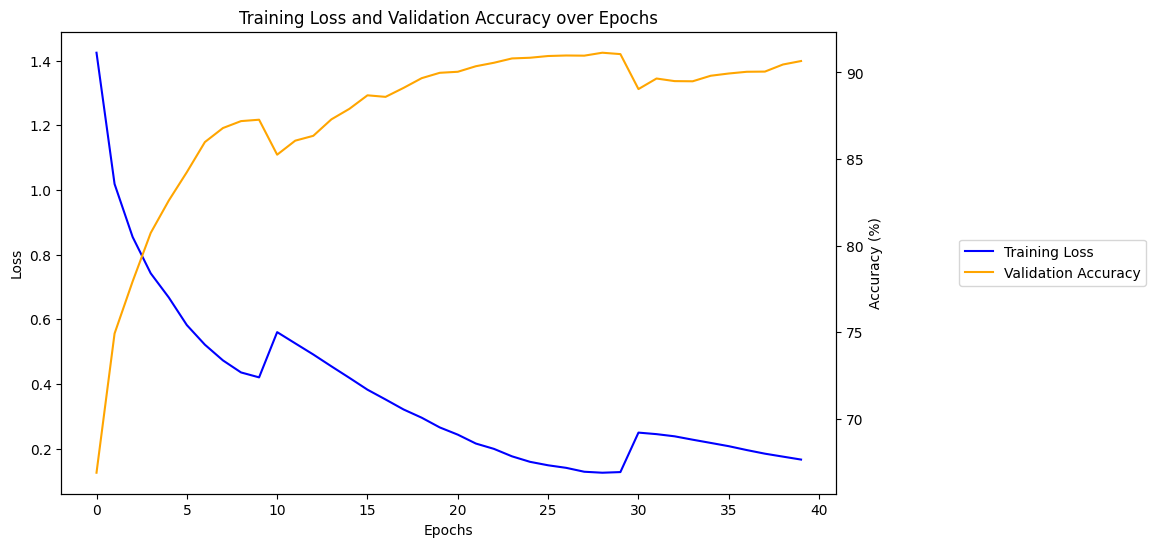

In [ ]:
# Plot both training loss and validation accuracy on the same figure
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot training loss on the primary y-axis
ax1.plot(losses, label="Training Loss", color="blue")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss and Validation Accuracy over Epochs")

# Create a secondary y-axis for validation accuracy
ax2 = ax1.twinx()
ax2.plot(validation_accuracies, label="Validation Accuracy", color="orange")
ax2.set_ylabel("Accuracy (%)")

# Combine legends from both axes and place them on the right center
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="center left", bbox_to_anchor=(1.15, 0.5))

plt.show()

In [ ]:
total_correct = 0
total_predictions = 0

# Loop over training dataset
for x_batch, y_batch in dataloader:
    logits = model(x_batch.to("cuda")) # Forward pass on the mini-batch
    loss = F.cross_entropy(logits.cpu(), y_batch) # Compute loss

    # Calculate predictions for the batch
    pred_labels = torch.max(logits, dim=1).indices

    # Update total correct predictions and total predictions
    total_correct += (y_batch == pred_labels.cpu()).sum().item()
    total_predictions += y_batch.size(0)

# Calculate overall accuracy
overall_accuracy = total_correct / total_predictions
print(f"Training Accuracy: {overall_accuracy}")

Training Accuracy: 0.99198


In [ ]:
total_correct = 0
total_predictions = 0

# Loop over testing dataset
for x_batch, y_batch in dataloader_test:
    logits = model(x_batch.to("cuda")) # Forward pass on the mini-batch
    loss = F.cross_entropy(logits.cpu(), y_batch) # Compute loss

    # Calculate predictions for the batch
    pred_labels = torch.max(logits, dim=1).indices

    # Update total correct predictions and total predictions
    total_correct += (y_batch == pred_labels.cpu()).sum().item()
    total_predictions += y_batch.size(0)

# Calculate overall accuracy and print it out.
overall_accuracy = total_correct / total_predictions
#DON'T FORGET TO PRINT OUT YOUR TESTING ACCURACY
print(f"Testting Accuracy: {overall_accuracy}")

Testting Accuracy: 0.9066
